In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os
import zipfile
train_bq_dir = os.path.join('//content/drive/My Drive/project_jpg/BadQuality_jpg')
train_gq_dir = os.path.join('/content/drive/My Drive/project_jpg/GoodQuality_jpg')

In [ ]:
train_gq_names = os.listdir(train_gq_dir)
print(train_gq_names[:10])

['TCIA_QIN_LUNGCT_QINLSC0003 (12).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (45).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (28).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (53).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (49).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (48).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (29).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (33).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (25).jpg', 'TCIA_QIN_LUNGCT_QINLSC0003 (32).jpg']


In [ ]:
print('total training good quality images:', len(os.listdir(train_gq_dir)))
print('total training bad quality images:', len(os.listdir(train_bq_dir)))

total training good quality images: 51
total training bad quality images: 40


In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(512, 512, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/project_jpg',  # This is the source directory for training images
        target_size=(512, 512),  # All images will be resized to 150x150
        batch_size=10,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 90 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=9,
      verbose=1)

Epoch 1/9
8/8 [==============================] - 23s 3s/step - loss: 0.9862 - acc: 0.6000
Epoch 2/9
8/8 [==============================] - 21s 3s/step - loss: 0.0882 - acc: 0.9875
Epoch 3/9
8/8 [==============================] - 21s 3s/step - loss: 0.0415 - acc: 0.9875
Epoch 4/9
8/8 [==============================] - 21s 3s/step - loss: 0.0017 - acc: 1.0000
Epoch 5/9
8/8 [==============================] - 21s 3s/step - loss: 0.0154 - acc: 1.0000
Epoch 6/9
8/8 [==============================] - 21s 3s/step - loss: 0.0015 - acc: 1.0000
Epoch 7/9
8/8 [==============================] - 21s 3s/step - loss: 2.6507e-05 - acc: 1.0000
Epoch 8/9
8/8 [==============================] - 21s 3s/step - loss: 2.5435e-05 - acc: 1.0000
Epoch 9/9
8/8 [==============================] - 21s 3s/step - loss: 1.6655e-05 - acc: 1.0000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


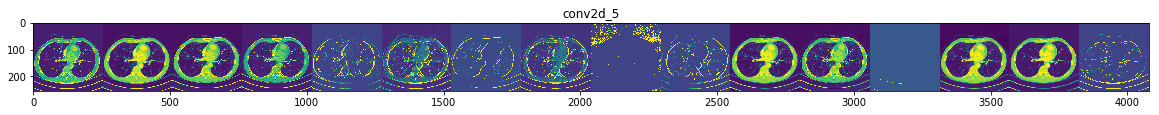

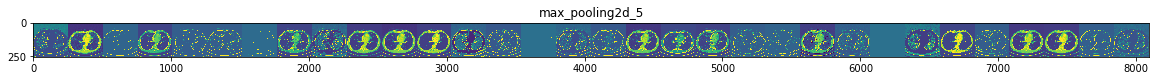

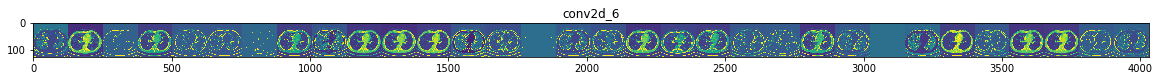

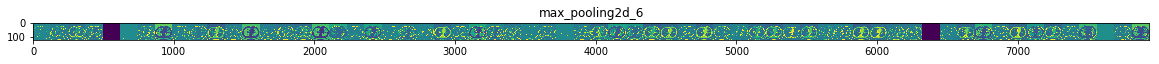

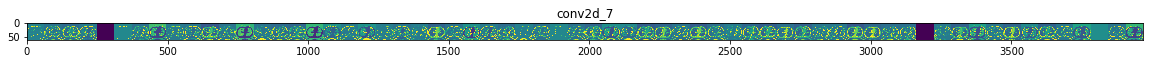

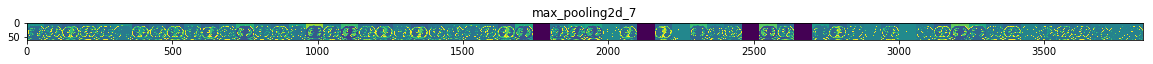

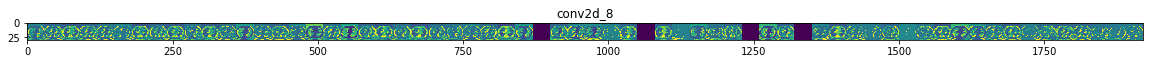

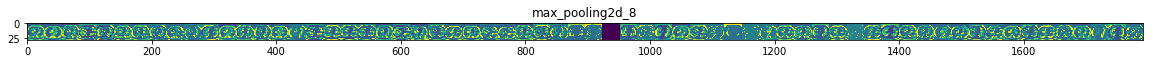

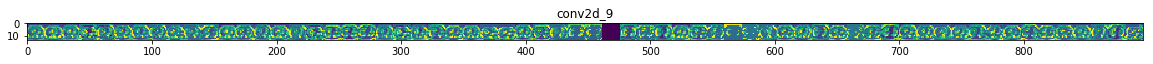

In [ ]:
import numpy as np
import random
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import img_to_array, load_img
train_bq_names = os.listdir(train_bq_dir)

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
bq_img_files = [os.path.join(train_bq_dir, f) for f in train_bq_names]
gq_img_files = [os.path.join(train_gq_dir, f) for f in train_gq_names]
img_path = random.choice(bq_img_files + gq_img_files)

img = load_img(img_path, target_size=(512, 512))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (512, 512, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')